# Demo No. 11 - Radial velocities fitting.

Following 2 demos will illustrate, how to proceed in case of the binary system with available radial velocities and photometric data. In this demo, we will focus on radial velocity data fitting using couple of methods.


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import numpy as np
import astropy.units as u

from elisa.conf import config
from elisa.analytics import RVData, RVBinaryAnalyticsTask
from elisa.analytics.params.parameters import BinaryInitialParameters


# setting up a custom logging config to prevent unreasonably long log messages during fit
config.LOG_CONFIG ='jupyter_fit_logging.json'
config.set_up_logging()  

As a start, we will create datasets containing observations of KIC 4851217 (Matson et al., 2017):

In [2]:
rv_primary = RVData.load_from_file('demo_data/rv_data/rv1.dat',  x_unit=u.d, y_unit=u.km/u.s)

rv_secondary = RVData.load_from_file('demo_data/rv_data/rv2.dat', x_unit=u.d, y_unit=u.km/u.s)

Lets finally define our starting parameters. Starting parameters are divided to `system`, `primary` and `secondary` category listed in form of dictionaries that contain name of the variable as a key and values contains dictionary characterizing starting value of the parameter, status of the parameter (`fixed`: True/False), the boundaries of the fitted parameter defined by `min`, `max` values and the unit in astropy format:

In [3]:
rv_init_params = {
    'system':{
        'eccentricity': {
            'value': 0.03,
            'fixed': False,
            'min': 0.00,
            'max': 0.04
        },
        'asini': {
            'value': 12,
            'fixed': False,
            'min': 8.0,
            'max': 15,
            'unit': u.solRad
        },
        'mass_ratio': {
            'value': 1.0,
            'fixed': False,
            'min': 0.9,
            'max': 1.2
        },
        'argument_of_periastron': {
            'value': 170,
            'fixed': False,
            'min': 0,
            'max': 360,
            'unit': u.deg
        },
        'gamma': {
            'value': -25.0,
            'fixed': False,
            'min': -30.0,
            'max': -10.0,
            'unit': u.km/u.s
        },
        'period': {
            'value': 2.47028376,
            'fixed': True,
        },
        'primary_minimum_time': {
            'value': 54953.8691,
            'fixed': False,
            'min': 54953.800,
            'max': 54954.000,
            'unit': u.d
        }
    }
}

This set of parameters is listed in format suitable for radial velocity fitting that uses parameters `system@asini`, `system@mass_ratio` instead of masses of the components (`primary@mass`, `secondary@mass`) and `system@inclination` parameter.

Subsequently, the dictionary with fit parameters will be now used to create object with fit parameters ready to be used inside fitting function:

In [4]:
rv_params = BinaryInitialParameters(**rv_init_params)

## Least squares method 

As a next step, we will create an `RVBinaryAnalyticsTask` on which we will perform fitting task itself utilizing least squares method:

In [5]:
lst_sqr_task = RVBinaryAnalyticsTask(data={'primary': rv_primary, 'secondary': rv_secondary}, method='least_squares')

Before fitting itself, you can access valid fit parmeter combinations in `standard` or `community` format: 

In [21]:
print(lst_sqr_task.FIT_PARAMS_COMBINATIONS)

{
    "community": {
        "system": [
            "mass_ratio",
            "asini",
            "eccentricity",
            "argument_of_periastron",
            "gamma",
            "period",
            "primary_minimum_time"
        ]
    },
    "standard": {
        "primary": [
            "mass"
        ],
        "secondary": [
            "mass"
        ],
        "system": [
            "inclination",
            "eccentricity",
            "argument_of_periastron",
            "gamma",
            "period",
            "primary_minimum_time"
        ]
    }
}


Lets finally start the fit itself using the following command (it will take a few seconds to complete):

In [7]:
lst_sqr_results = lst_sqr_task.fit(x0=rv_params)
lst_sqr_results

2020-06-01 09:50:42,497 - 778 - analytics.binary_fit.least_squares - INFO: fitting radial velocity light curve...
2020-06-01 09:51:19,022 - 778 - analytics.binary_fit.least_squares - INFO: fitting finished...
2020-06-01 09:51:19,036 - 778 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results finished successfully.

------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            1.077                   -                   -                   -    Variable                                          
a*sin(i):                                          11.86             

{'system': {'eccentricity': {'value': 0.012841539185203917,
   'fixed': False,
   'unit': None,
   'min': 0.0,
   'max': 0.04},
  'argument_of_periastron': {'value': 260.91335162887475,
   'fixed': False,
   'unit': 'deg',
   'min': 0.0,
   'max': 360.0},
  'gamma': {'value': -24507.117008277703,
   'fixed': False,
   'unit': 'm / s',
   'min': -30000.0,
   'max': -10000.0},
  'mass_ratio': {'value': 1.0772998575305697,
   'fixed': False,
   'unit': None,
   'min': 0.9,
   'max': 1.2},
  'asini': {'value': 11.85704599842232,
   'fixed': False,
   'unit': 'solRad',
   'min': 8.0,
   'max': 15.0},
  'primary_minimum_time': {'value': 54953.87259134054,
   'fixed': False,
   'unit': 'd',
   'min': 54953.8,
   'max': 54954.0},
  'period': {'value': 2.47028376, 'fixed': True, 'unit': 'd'}},
 'r_squared': {'value': 0.9935322267459304, 'unit': None}}

We can see that the function provided a summary of the fit (which can be now accessed via command `task.result_summary(filename=)`) and returned the results in the same form as the starting parameters.

Finally, we can visualize the resulting fit:

<IPython.core.display.Javascript object>


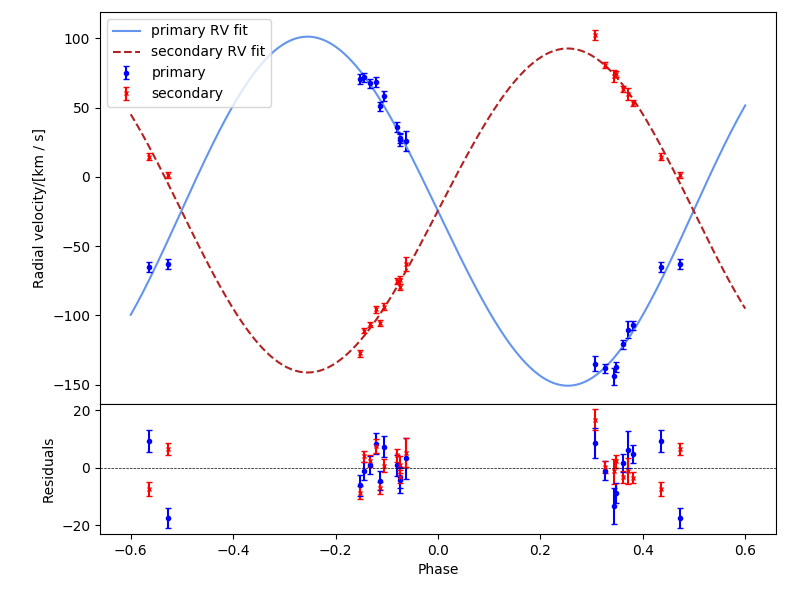

In [8]:
lst_sqr_task.plot.model()

We will now store the resulting parameters into file that we will use later (parameters can be loaded using `lst_sqr_task.load_result(filename)`):

In [9]:
param_file = 'demo_data/aux/rv_lstsqr_params.json'
lst_sqr_task.save_result(param_file)

## Markov chain Monte Carlo (MCMC)

Using the MCMC we can estimate confidence intervals of the fitted parameters which was not possible in least squares method. Unfortunatelly, this capability is at the expense of speed and therefore this method is meant to be used as a follow-up to the least squares method. To speed-up the initiall burn-in phase, we will update the current initial values to the results obtained in least squares method:

In [10]:
rv_params = BinaryInitialParameters(**lst_sqr_results)

We have to also create a new fitting task instance dedicated with `mcmc` method specified: 

In [11]:
mcmc_task = RVBinaryAnalyticsTask(data={'primary': rv_primary, 'secondary': rv_secondary}, method='mcmc')

Updated starting parameters can be now used in a very similar fashion to least squares method to perform MCMC sampling. Notice the `save` and `fit_id` parameter that is used to store fit results in Elisa `$HOME/mcmc_rv_fit/(fit_id).json`. You can also specify full path to the file in `fit_id_parameter`:

In [12]:
my_fit_id = "mcmc_rv_fit"

In [13]:
mcmc_results = mcmc_task.fit(x0=rv_params, nsteps=1000, burn_in=10, save=True, fit_id=my_fit_id, progress=True)
mcmc_results

2020-06-01 09:51:19,490 - 778 - analytics.binary_fit.mcmc - INFO: starting mcmc
2020-06-01 09:51:19,494 - 778 - analytics.binary_fit.mcmc - INFO: starting singlecore mcmc
2020-06-01 09:51:19,499 - 778 - analytics.binary_fit.mixins - INFO: running burn-in...


100%|██████████| 10/10 [00:00<00:00, 11.68it/s]

2020-06-01 09:51:20,478 - 778 - analytics.binary_fit.mixins - INFO: running production...



100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]


2020-06-01 09:52:59,232 - 778 - analytics.binary_fit.mixins - INFO: MCMC chain, variable`s fitable and normalization constants were stored in: /home/cepheus/.elisa/mcmc_rv_fit/mcmc_rv_fit.json
2020-06-01 09:52:59,259 - 778 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results finished successfully.

------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            1.077               0.014               0.014                   -    Variable                                          
a*sin(i):                                          11.86                0.18         

{'system': {'eccentricity': {'value': 0.013691759518816885,
   'confidence_interval': {'min': 0.008068154894649945,
    'max': 0.01890799396112809},
   'fixed': False,
   'min': 0.0,
   'max': 0.04,
   'unit': None},
  'argument_of_periastron': {'value': 278.6689509974394,
   'confidence_interval': {'min': 230.81290991200072,
    'max': 314.9022265174117},
   'fixed': False,
   'min': 0.0,
   'max': 360.0,
   'unit': 'deg'},
  'gamma': {'value': -24406.252730198295,
   'confidence_interval': {'min': -24970.39043329954,
    'max': -23819.955888588625},
   'fixed': False,
   'min': -30000.0,
   'max': -10000.0,
   'unit': 'm / s'},
  'mass_ratio': {'value': 1.0770504923745552,
   'confidence_interval': {'min': 1.0635197818969504,
    'max': 1.0909381708506733},
   'fixed': False,
   'min': 0.9,
   'max': 1.2,
   'unit': None},
  'asini': {'value': 11.855531751764781,
   'confidence_interval': {'min': 11.679929400723662,
    'max': 12.025254822007422},
   'fixed': False,
   'min': 8.0,
  

We can inspect the results by examining a correlation diagrams in the corner plot:

<IPython.core.display.Javascript object>


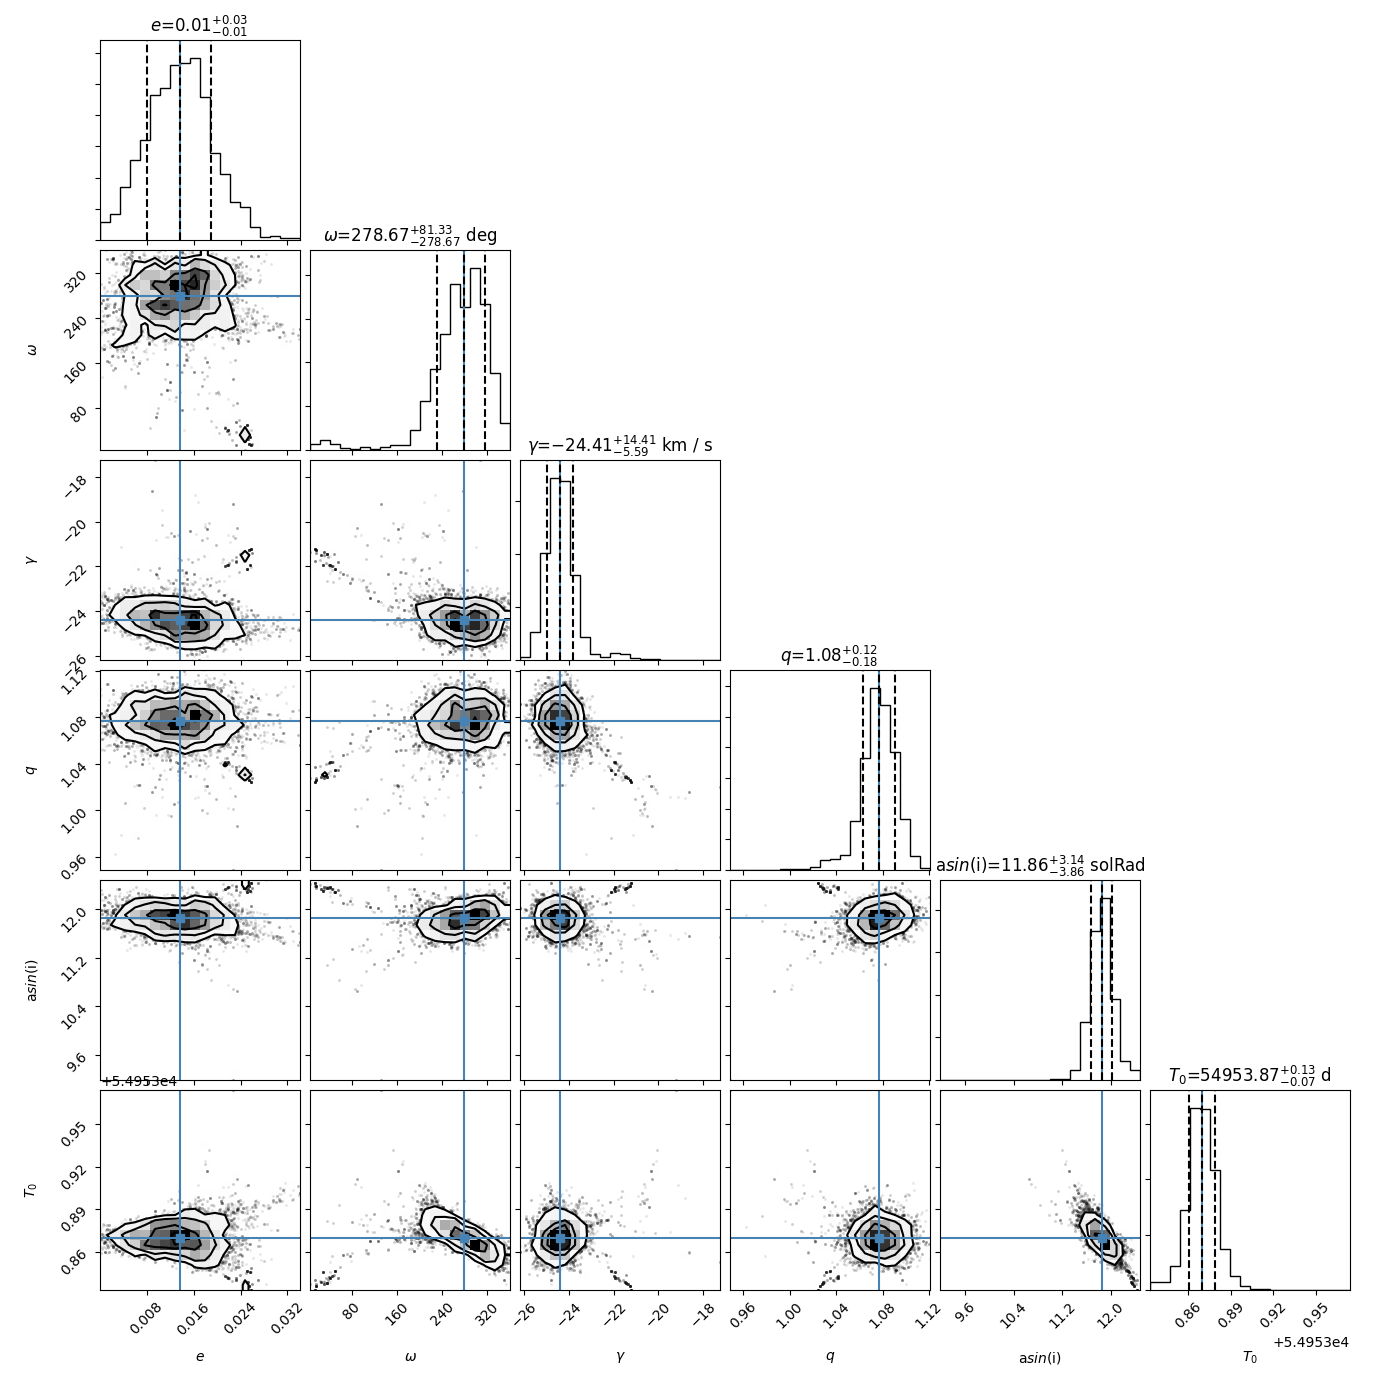

In [14]:
mcmc_task.plot.corner(truths=True)

Traces can be also investgated:

<IPython.core.display.Javascript object>


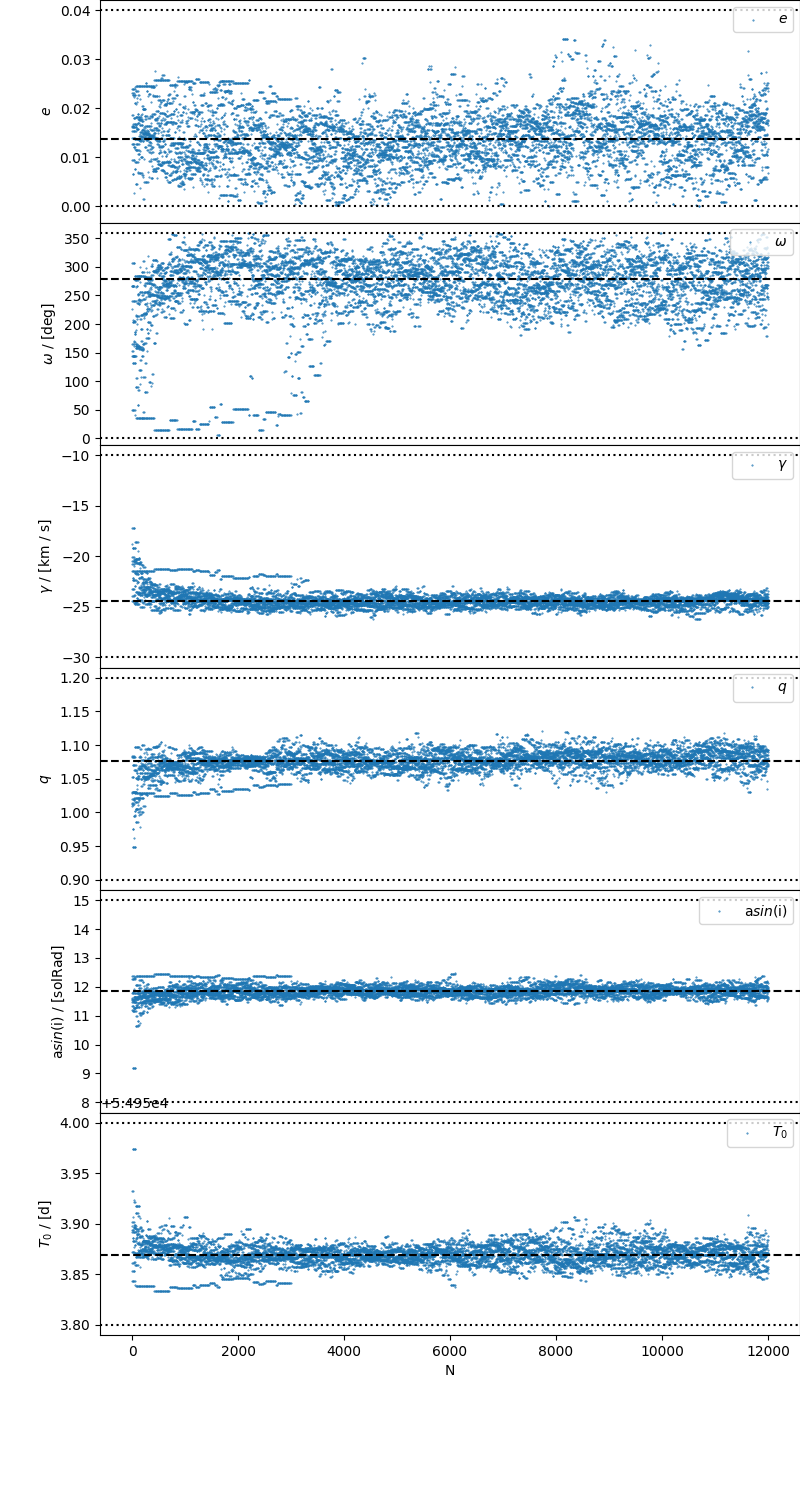

In [15]:
mcmc_task.plot.traces(truths=True)

Along with autocorrelation function and autocorrelation times:

2020-06-01 09:53:02,171 - 778 - root - WARNING: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 240;
tau: [295.80739856]
2020-06-01 09:53:02,178 - 778 - root - WARNING: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 240;
tau: [265.47527069]


<IPython.core.display.Javascript object>


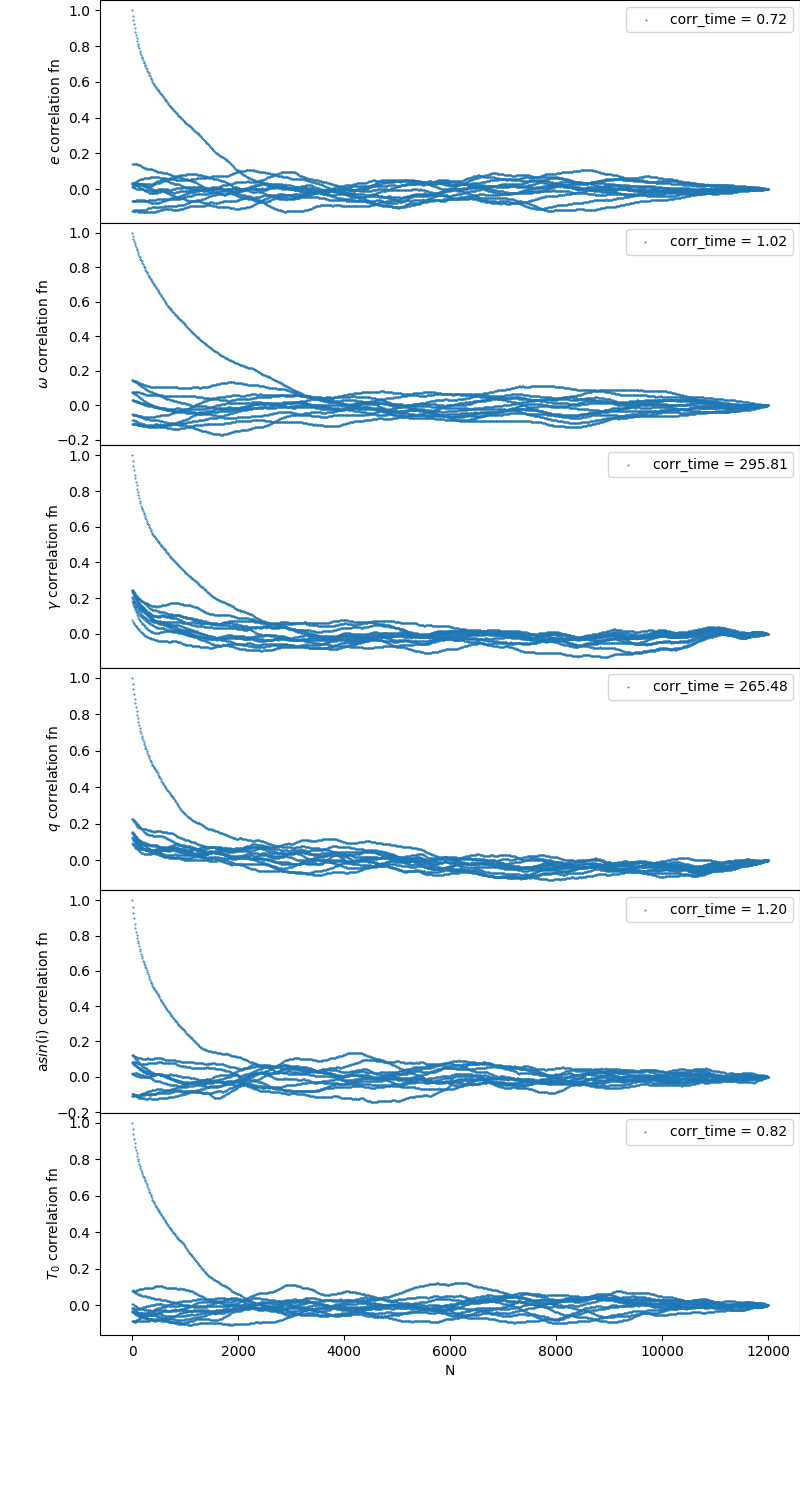

In [16]:
mcmc_task.plot.autocorrelation()

As you can (probably) see in this example, 10 steps in `burn_in` phase was not sufficient to de-correlate all of the chains. This can be remedied easily by incrasing the the number of iterations or by specifying longer `burn_in` argument in `fit` function.

Due to the fact, that the MCMC method is very time demanding method, the resulting chain ican be recovered using your `fit_id` identificator (or path), where you can use discard parameter to filter out the thermalization stage of your chain:

In [17]:
mcmc_task.load_chain(my_fit_id, discard=1000)

Modified chain can be used to produce more precise fit summary (where `filename` argument can be used to write the summary to file):

In [18]:
mcmc_task.result_summary()


------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            1.078               0.013               0.013                   -    Variable                                          
a*sin(i):                                          11.87                0.17                0.16              solRad    Variable                                          
Eccentricity (e):                                 0.0136              0.0055              0.0052                   -    Variable                                          
Argument of periastron (omega):                    281.0     

<IPython.core.display.Javascript object>


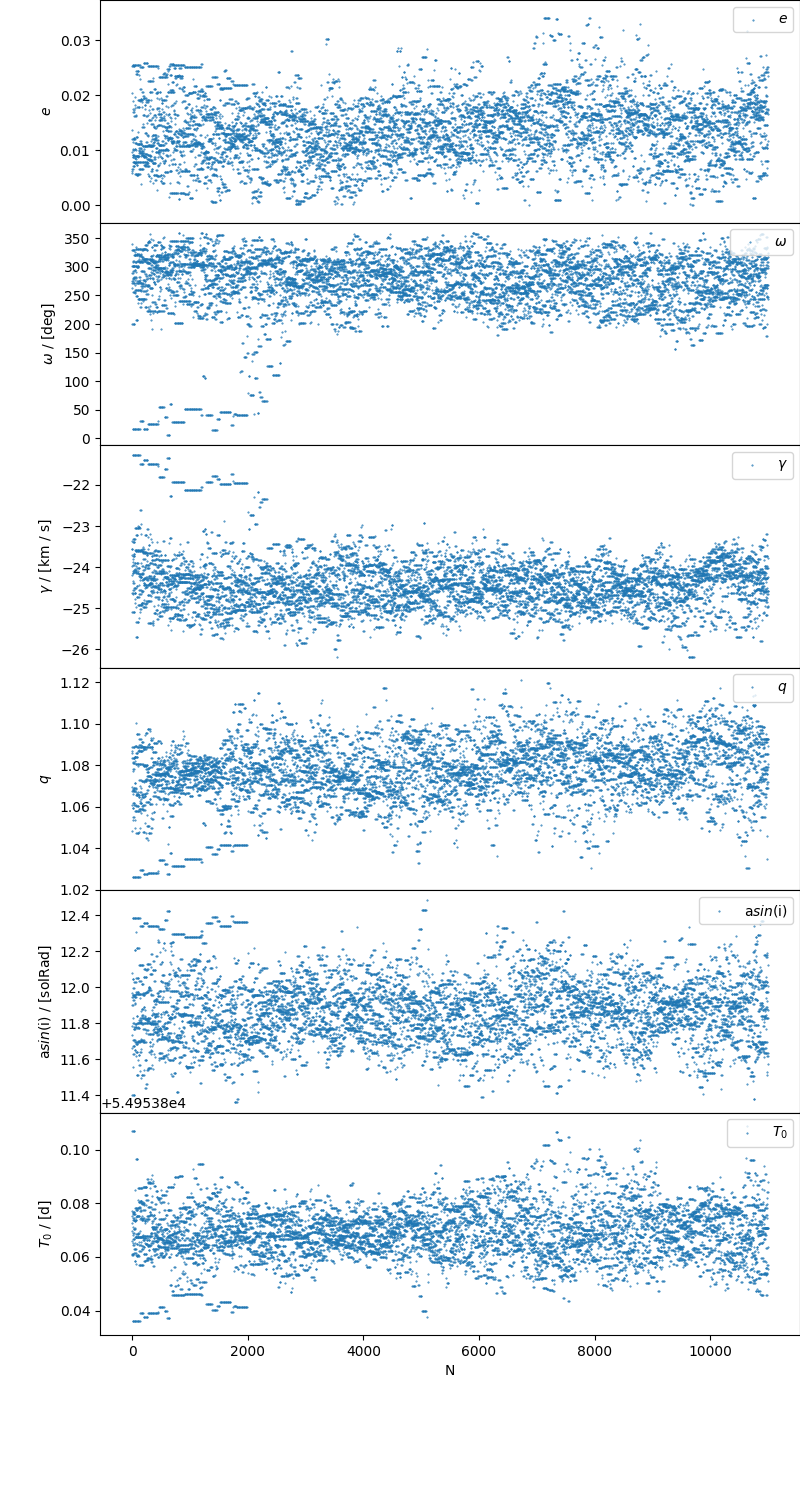

In [19]:
mcmc_task.plot.traces()

## References:

Matson, R. A.; Gies, D. R.; Guo, Z.; Williams, S. J. 2017, AJ, 154, 6, 216